In [14]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import desispec.io
from astropy.io import fits
from astropy.table import Table
%matplotlib inline


 The purpose of this notebook is: 

i) to test the reproducibility of quasar spectra simulated using desisim quickquasars when adding different features such as DLAs, BALs, and metals. 

ii) Explore the information that is being saved in the truth files

In [15]:
##These lines are only needed if one is using local branch.
#Make sure that the branch you want to use is active in your local directory in cori if your using this notebook in jupyer-dev.nersc.. 
#To use de master branch of all codes from jupyter-dev.nersc, just mark down this cell. 

os.environ['PYTHONPATH']='/global/homes/a/alxogm/desi/code/desisim/py:'+os.environ['PYTHONPATH']
os.environ['PATH']='/global/homes/a/alxogm/desi/code/desisim/bin/:'+os.environ['PATH']


### Lets define some plotting functions, that will be useful along the notebook. 

In [16]:
#A simple filter was added to retain some of the noise and check this is reproduced, but still be able to spot differences due to features by eye. Plotspec routine was taken from someother tutorial. It allows to add the true spectra although we will not use this option here 
#Thes plots will show the three arms of the spectrograph in colors blue ['b'], red ['r'] and yellow ['z'].

from scipy.signal import medfilt
def plotspec(spectra, i, truewave=None, trueflux=None, color=['b','r','y'],nfilter=11,label=None):
    plt.plot(spectra.wave['b'], medfilt(spectra.flux['b'][i], nfilter), color=color[0], alpha=0.5,label=label)
    plt.plot(spectra.wave['r'], medfilt(spectra.flux['r'][i], nfilter), color=color[1], alpha=0.5)
    plt.plot(spectra.wave['z'], medfilt(spectra.flux['z'][i], nfilter), color=color[2], alpha=0.5)
    if truewave is not None and trueflux is not None:
        plt.plot(truewave, trueflux[i], 'k-')

    plt.axhline(0, color='k', alpha=0.2)
        
    ymax = 5
    ymin=0
        
    plt.ylim(ymin, ymax+0.5)
    plt.ylabel('Flux')
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    return
    
#This will compare two spectra by dividing the first over the second
def plotspec_ratio(spectra1,spectra2,i,label=None):
    ratio_b=spectra1.flux['b'][i]/spectra2.flux['b'][i]
    ratio_r=spectra1.flux['r'][i]/spectra2.flux['r'][i]
    ratio_z=spectra1.flux['z'][i]/spectra2.flux['z'][i]
    plt.plot(spectra1.wave['b'],ratio_b, color='b', alpha=0.5,label=label)
    plt.plot(spectra1.wave['r'], ratio_r, color='r', alpha=0.5)
    plt.plot(spectra1.wave['z'], ratio_z, color='y', alpha=0.5)
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    
#This will compare two spectra by substracting the second from the first one
def plotspec_diff(spectra1,spectra2,i,label=None):
    ratio_b=spectra1.flux['b'][i]-spectra2.flux['b'][i]
    ratio_r=spectra1.flux['r'][i]-spectra2.flux['r'][i]
    ratio_z=spectra1.flux['z'][i]-spectra2.flux['z'][i]
    plt.plot(spectra1.wave['b'],ratio_b, color='b', alpha=0.5,label=label)
    plt.plot(spectra1.wave['r'], ratio_r, color='r', alpha=0.5)
    plt.plot(spectra1.wave['z'], ratio_z, color='y', alpha=0.5)
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    
#This is only to compute the observed wavelenght of given line that corresponds to the quasar redshift. e.g 

def draw_obsline(lbda,z):
    return (1.+z)*lbda




### Now, lets define the base parameters of our simulations. As well as the paths to where the transmission file will be read. One of the important things is to define a seed that will be used in all the spectra simulations. 

#### If you want to run a full simulation it is best you do it using the slurmscript https://github.com/desihub/desisim/blob/master/etc/quickquasar_slurm_script.sh

In [17]:
ifile='/global/cfs/cdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz'   #Choose one pixel to simulate the quasars. 
outdir='/pscratch/sd/a/alxogm/tests/test_reproducibility/'  #Where do you want to save the files, although in this particular notebook we will be overwritring the files. 
version=2
zmin=1.8
nmax=20   #máximum number of spectra to simulate in a pixel .
seed=0  #Seed to ensure reproducibility. 

In [18]:
#Check if output directory exist, otherwise create it. 
if not os.path.isdir(outdir):
    os.mkdir(outdir)

### First we run quickquasars twice. One with an exposure time of 4000 (four passes) and another run with exptime=1e10 (noiseless)

In [36]:
#WARNING: By default we will be continusly overwritting files in this notebook.
#If you really want to save the files please indicate a diffrent filename each time you run a cell like this one. 
sysopt=0
exptime=4   #Exposure time

cmd =f'quickquasars  -i {ifile} --outdir {outdir}/test-{version}.{sysopt}-{exptime}/spectra-16 --zmin {zmin} --overwrite \
--nmax {nmax} --seed {seed} --exptime {exptime*1000} '  
!time $cmd

INFO:quickquasars.py:943:main: Load SIMQSO model
INFO:quickquasars.py:952:main: Load DeCAM and WISE filters for target selection sim.
ifilename /global/cfs/cdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:227:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:232:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:240:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:323:simulate_one_healpix: Read skewers in /global/cfs/cdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 17227
INFO:quickquasars.py:327:simulate_one_healpix: Read transmission file /global/cfs/cdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:332:simulate_one_healpix: Add FOG to redshift with sigma 150 to quasar redshift
INFO:quickquasars.py:375:simulate_one_healpix: Select QSOs in DESI footprint 2577 -> 2577
INFO:quickquasars.py:385:simulate_one_healpix: Res

In [9]:
spec_exp1e4=desispec.io.read_spectra(outdir+"/test-2.0-4/spectra-16/0/0/spectra-16-0.fits")


INFO:spectra.py:291:read_spectra: iotime 0.014 sec to read spectra-16-0.fits at 2022-11-09T17:15:43.279887


In [12]:
#Now we run the same simulation but with a higer exposure time. 
sysopt=0
exptime=10000000   #Exposure time
cmd =f'quickquasars  -i {ifile} --outdir {outdir}/test-{version}.{sysopt}-{exptime}/spectra-16 --zmin {zmin} --zbest --bbflux --desi-footprint --overwrite \
--nmax {nmax} --seed {seed} --exptime {exptime*1000}'  
!time $cmd

INFO:quickquasars.py:943:main: Load SIMQSO model
INFO:quickquasars.py:952:main: Load DeCAM and WISE filters for target selection sim.
ifilename /global/cfs/cdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:227:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:232:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:240:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:323:simulate_one_healpix: Read skewers in /global/cfs/cdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 17227
INFO:quickquasars.py:327:simulate_one_healpix: Read transmission file /global/cfs/cdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:332:simulate_one_healpix: Add FOG to redshift with sigma 150 to quasar redshift
INFO:quickquasars.py:375:simulate_one_healpix: Select QSOs in DESI footprint 2577 -> 2577
INFO:quickquasars.py:385:simulate_one_healpix: Res

### Lets make a first plot, comparing the noise and no noise base spectra. 

INFO:spectra.py:291:read_spectra: iotime 0.013 sec to read spectra-16-0.fits at 2022-11-09T17:16:22.778238


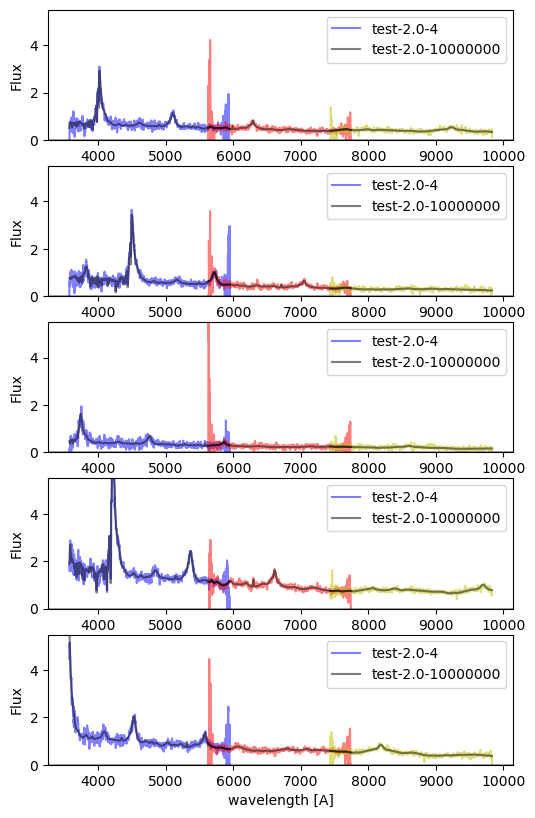

In [13]:
spec_noisless=desispec.io.read_spectra(outdir+"/test-2.0-10000000/spectra-16/0/0/spectra-16-0.fits")
plt.figure(figsize=(6,10),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec(spec_exp1e4, i,label='test-2.0-4')
    plotspec(spec_noisless, i,color=['k','k','k'],label='test-2.0-10000000')



## Now we run a case adding DLAs and metals from transmision files, as well as BALs.  

In [15]:

sysopt=134
exptime=4   #Exposure time
cmd =f'quickquasars  -i {ifile} --outdir {outdir}/test-{version}.{sysopt}-{exptime}/spectra-16 --zmin {zmin} --zbest --bbflux --desi-footprint --overwrite \
--nmax {nmax} --seed {seed} --exptime {exptime*1000} '  
cmd +=f'--dla file --metals-from-file all --add-LYB --bal 0.16'
!$cmd

INFO:quickquasars.py:911:main: Creating dir /pscratch/sd/a/alxogm/tests/test_reproducibility//test-2.134-4/spectra-16
INFO:quickquasars.py:943:main: Load SIMQSO model
INFO:quickquasars.py:952:main: Load DeCAM and WISE filters for target selection sim.
INFO:io.py:971:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/bal_templates_v3.0.fits
ifilename /global/cfs/cdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:227:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:232:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:240:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:316:simulate_one_healpix: Creating dir /pscratch/sd/a/alxogm/tests/test_reproducibility//test-2.134-4/spectra-16/0/0
INFO:quickquasars.py:323:simulate_one_healpix: Read skewers in /global/cfs/cdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 17227
INFO:quickqua

INFO:spectra.py:291:read_spectra: iotime 0.016 sec to read spectra-16-0.fits at 2022-11-09T17:17:01.515648


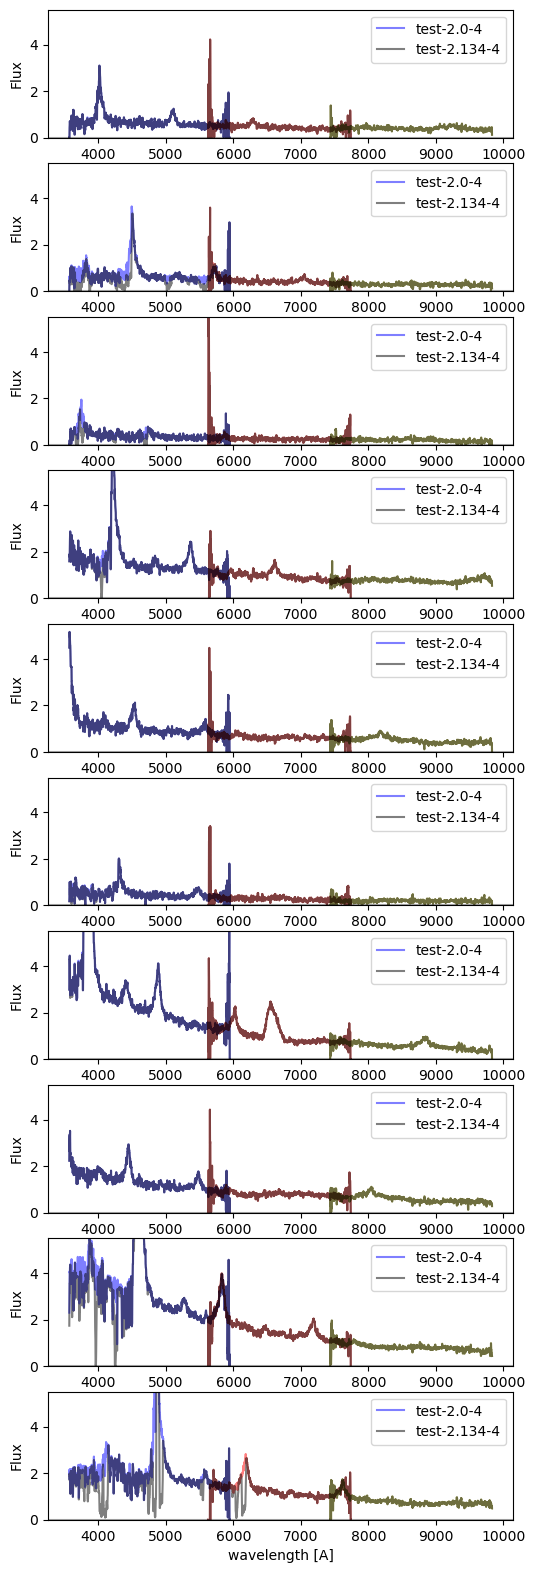

In [16]:
spec_134_exp1e4=desispec.io.read_spectra(outdir+"/test-2.134-4/spectra-16/0/0/spectra-16-0.fits")
plt.figure(figsize=(6,20),dpi=100)
for i in range(10):
    plt.subplot(10,1,i+1)
    plotspec(spec_exp1e4, i,label='test-2.0-4')

    plotspec(spec_134_exp1e4, i,color=['k','k','k'],label='test-2.134-4')


We can notice how the noise and continuum is the same for the two realizations, and spectra only differs where there is a BAL or DLA present. Smaller differences are also due to the presence of the metal absorptions, but those are not apreciated in this comparison. Lets plot the difference between the spectra in order to highlight the different features of the simulated spectra. 

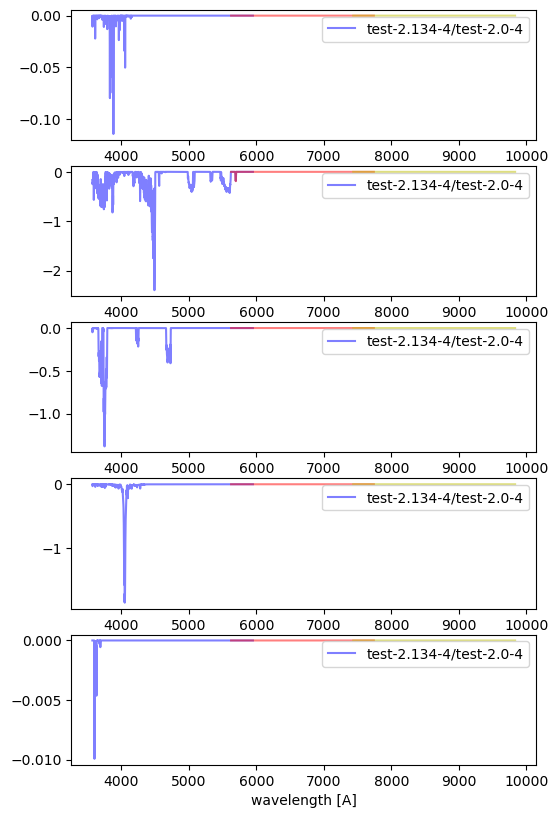

In [17]:
plt.figure(figsize=(6,10),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec_diff(spec_134_exp1e4,spec_exp1e4,i,label='test-2.134-4/test-2.0-4')


Now that we have seen that the noise and contiuum is reproducible for different realizations of the mocks. Lets explore what information is being saved in the truth files. 
Lets open first the truth file of the run withouth contaminants

In [50]:
truth=fits.open(outdir+"/test-2.134-4/spectra-16/0/0/truth-16-0.fits")

In [51]:
truth.info()

Filename: /pscratch/sd/a/alxogm/tests/test_reproducibility//test-2.134-4/spectra-16/0/0/truth-16-0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  TRUTH         1 BinTableHDU     51   20R x 18C   [K, 10A, 10A, I, K, D, E, 15A, E, E, E, E, E, E, D, D, D, E]   
  2  TRUTH_QSO     1 BinTableHDU     24   20R x 6C   [K, E, 5E, 186E, I, L]   
  3  DLA_META      1 BinTableHDU     17   21R x 4C   [D, D, K, K]   
  4  BAL_META      1 BinTableHDU     54   3R x 18C   [K, E, E, K, E, E, J, 5E, 5E, 5E, 5E, E, E, J, 27E, 27E, 27E, 27E]   
  5  B_RESOLUTION    1 ImageHDU         8   (2975, 11)   float32   
  6  R_RESOLUTION    1 ImageHDU         8   (2645, 11)   float32   
  7  Z_RESOLUTION    1 ImageHDU         8   (2999, 13)   float32   


In real data, the resolution per band is saved in each of the spectra files. In our simulated data we save space by saving it only once in the truth file. 

The "TRUTH" table stores information about the target id, the seed used to generate the template, the magnitud in the diferent bands, the true redshift, and the different contributions to it. 

In [52]:
print(Table(truth["TRUTH"].data).colnames)

['TARGETID', 'OBJTYPE', 'SUBTYPE', 'TEMPLATEID', 'SEED', 'Z', 'MAG', 'MAGFILTER', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'TRUEZ', 'Z_INPUT', 'DZ_FOG', 'DZ_SYS', 'Z_NORSD']


In [53]:
Table(truth["TRUTH"].data)

TARGETID,OBJTYPE,SUBTYPE,TEMPLATEID,SEED,Z,MAG,MAGFILTER,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,TRUEZ,Z_INPUT,DZ_FOG,DZ_SYS,Z_NORSD
int64,str10,str10,int16,int64,float64,float32,str15,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32
112067,QSO,,0,1345093830,2.2982850074768066,21.870823,decam2014-r,1.4619827,1.7851329,2.9900887,5.9714055,10.740225,2.298285,2.298476571056048,-0.00019156357924144952,0.0,2.299399
61542,QSO,,1,1345093830,2.6951067447662354,21.894344,decam2014-r,1.6175307,1.7468767,2.1862419,3.7505965,6.198459,2.6951067,2.6936487385899017,0.001458006176333688,0.0,2.698059
114938,QSO,,2,1345093830,2.0734939575195312,22.547714,decam2014-r,0.77454907,0.9570044,1.4201245,3.3494587,6.2461567,2.073494,2.0745555310985315,-0.0010615735790003027,0.0,2.0743496
119606,QSO,,3,1345093830,2.466230630874634,21.04219,decam2014-r,3.5175261,3.829341,5.804608,7.2383995,13.517294,2.4662306,2.4658903502897327,0.00034028058490108865,0.0,2.4695683
119390,QSO,,4,1345093830,1.9246697425842285,21.525473,decam2014-r,2.0618265,2.453641,3.223866,7.785634,13.608329,1.9246697,1.9253427394986715,-0.000672996914442989,0.0,1.9245597
114392,QSO,,5,1345093830,2.5373339653015137,22.373524,decam2014-r,1.0851704,1.123545,1.4990361,2.2323182,3.1440053,2.537334,2.5352797905832696,0.0020541747182441154,0.0,2.5355835
113786,QSO,,6,1345093830,2.1574740409851074,20.871302,decam2014-r,4.5595226,4.482076,3.9629066,3.0375586,4.9132643,2.157474,2.1576274203047086,-0.00015337931960124197,0.0,2.1565013
116183,QSO,,7,1345093830,1.8733971118927002,21.267296,decam2014-r,2.7914088,3.1123013,3.7725484,6.4744487,12.0997,1.8733971,1.8710497150446428,0.002347396848057502,0.0,1.8749633
117521,QSO,,8,1345093830,2.7691874504089355,20.500282,decam2014-r,7.6408844,6.30793,5.818279,3.4383423,5.315065,2.7691875,2.7694752617003497,-0.0002878112914144142,0.0,2.774042


On the other hand, the "TRUTH_QSO" table have information about the parameters used for the quasar continuum, the parameters of the emision lines included, and whether its a BAL and if it have a DLA. If the template is a BAL it will show the BAL_TEMPLATEID and if it will specify if it has a BAL or not. 

In [56]:
print(Table(truth["TRUTH_QSO"].data).colnames)

['TARGETID', 'MABS_1450', 'SLOPES', 'EMLINES', 'BAL_TEMPLATEID', 'DLA']


In [57]:
Table(truth["TRUTH_QSO"].data)

TARGETID,MABS_1450,SLOPES [5],"EMLINES [62,3]",BAL_TEMPLATEID,DLA
int64,float32,float32,float32,int16,bool
112067,-22.674007,-2.3036854 .. -0.878942,1216.77 .. 7.087997,-1,False
61542,-23.09222,-1.5845205 .. -1.101673,1216.77 .. 6.294785,977,False
114938,-21.823566,-1.2621596 .. -1.1761705,1216.77 .. 6.7852545,475,False
119606,-23.750687,-1.819695 .. -0.93981117,1216.77 .. 5.6560793,-1,False
119390,-22.70665,-1.1373668 .. -1.0611689,1216.77 .. 5.6414995,-1,False
114392,-22.563625,-1.2876588 .. -0.58271855,1216.77 .. 5.956779,-1,False
113786,-23.882803,-1.4410776 .. -0.8276916,1216.77 .. 5.855661,-1,False
116183,-22.978771,-1.4941866 .. -1.157066,1216.77 .. 6.7556114,-1,False
117521,-24.716139,-1.171753 .. -0.66159654,1216.77 .. 6.5342264,-1,False


It there are BALs then another table with the BAL information is available. 

In [63]:
Table(truth["BAL_META"].data)

TARGETID,Z,BAL_PROB,BAL_TEMPLATEID,BI_CIV,ERR_BI_CIV,NCIV_2000,VMIN_CIV_2000 [5],VMAX_CIV_2000 [5],POSMIN_CIV_2000 [5],FMIN_CIV_2000 [5],AI_CIV,ERR_AI_CIV,NCIV_450,VMIN_CIV_450 [27],VMAX_CIV_450 [27],POSMIN_CIV_450 [27],FMIN_CIV_450 [27]
int64,float32,float32,int64,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32
61542,2.6951067,1.0,977,3192.9417,15.164653,1,13518.649 .. -1.0,5362.85 .. -1.0,6242.802 .. -1.0,0.1428748 .. -1.0,3178.969,15.082281,4,21256.277 .. 0.0,20678.447 .. 0.0,21063.824 .. 0.0,0.5977633 .. 0.0
114938,2.073494,1.0,475,888.8185,7.33396,1,6472.417 .. -1.0,3007.6094 .. -1.0,4711.143 .. -1.0,0.03475149 .. -1.0,2495.1948,12.252717,2,21281.887 .. 0.0,20704.08 .. 0.0,20896.912 .. 0.0,0.061969668 .. 0.0
122448,2.9960284,1.0,182,-3.568885,2.568345,1,7683.2437 .. -1.0,5522.936 .. -1.0,7414.0317 .. -1.0,-0.06034077 .. -1.0,2994.472,10.855923,2,7683.2437 .. 0.0,5929.269 .. 0.0,7414.0317 .. 0.0,-0.06034077 .. 0.0


The BAL_TEMPLATEID can be used to retrive the BAL template used from `/global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/bal_templates_v3.0.fits`


And similarly, if there are DLAs there is another table with DLA information. 

In [64]:
Table(truth["DLA_META"].data)

NHI,Z_DLA,TARGETID,DLAID
float64,float64,int64,int64
20.144342067172587,2.184361847876019,61542,61542000
18.247571223249714,2.504998897380797,61542,61542001
17.507731465802966,2.517483271491078,61542,61542002
17.455254085829907,2.6193944108433866,61542,61542003
20.23423694375398,2.329602467668033,119606,119606000
18.451098456688754,2.2655942220991445,114392,114392000
20.20637770479673,2.2594456088371038,117521,117521000
20.408238692897115,2.496655468670317,117521,117521001
17.985511987163342,2.600489532898868,117521,117521002


Both the DLA and BAL truth tables can be used as BAL/DLA catalogs to be used in picca. 